In [95]:
# this notebook is dedicated to making figures for my csdms 2022 poster
# these figures will aim to capture "5 criteria" that the model meets
# there criteria are: (getting deleted as they are fulfilled)

# STEADY STATE
## increasing steepness with increasing uplift rate
## steady state width?
## increased concavity (and steepness?) with two lithologies when compared to single lithology

## TRANSIENT
# upstream migrating knickpoints (response to baselevel fall)

In [96]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [97]:
# SET UP GRID ARRAYS
dx_2 = 1000
x_2 = np.arange(0, 100000, dx_2)

# set up runoff rate
r_2 = np.zeros(len(x_2))
r_2[:] = 0.3

# set up references to topography
Hstar_2 = 0.1
H_2 = Hstar_2 + np.zeros(len(x_2))
etab_2 = -H_2
eta_2 = etab_2 + H_2

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig_2 = np.zeros(len(x_2))
beta_ig_2[:25] = 0.00004
beta_sed_2 = np.zeros(len(x_2))
beta_sed_2[25:] = 0.00014
atr_factor_2 = 0.00004

# erodibility values
k_ig_2 = np.zeros(len(x_2))
k_ig_2[:25] = 0.0001
k_sed_2 = np.zeros(len(x_2))
k_sed_2[25:] = 0.001

In [98]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     atr_factor,
                     k_ig,
                     k_sed,
                     r,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 500000, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    q = r * x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt_global = 0.2 * dx * dx / (c*q[-1])  # "global" time-step size
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[1:])   # <== change indexing: qs[1] represents node 0
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        #  calc grain attrition rate
        atr = atr_factor * qs[1:]
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        
        
        # Calculate maximum allowable time-step size
        
        #  track total erosion rate
        total_ero[:-1] = bedrock_ero[:-1] - sedimentation_rate[:-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
        if any(total_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print(cum_time)
        
    return (S, qs, efac, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, atr, 
            sedimentation_rate, H, total_ero, cum_time)

In [99]:
# design experiment to check out concave upward steady state profile
# cu stands for concave up
CU = [x_2, dx_2, Hstar_2, H_2, etab_2, eta_2, beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2]

# and run away with it!
(slope_CU,
 sed_flux_CU,
 e_factor_CU,
 topography_CU,
 bedrock_elevation_CU,
 igneous_plucking_rate_CU,
 sedimentary_plucking_rate_CU,
 igneous_abrasion_rate_CU,
 sedimentary_abrasion_rate_CU,
 bedrock_erosion_rate_CU,
 attrition_rate_CU,
 sedimentation_rate_CU,
 sediment_thickness_CU,
 total_erosion_rate_CU,
 cum_time_CU) = two_lith_one_sed(*CU)

3367003.3670325675


In [100]:
# now check it's at steady state
print(total_erosion_rate_CU)

[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001]


In [101]:
adjustment_CU = topography_CU[-1]

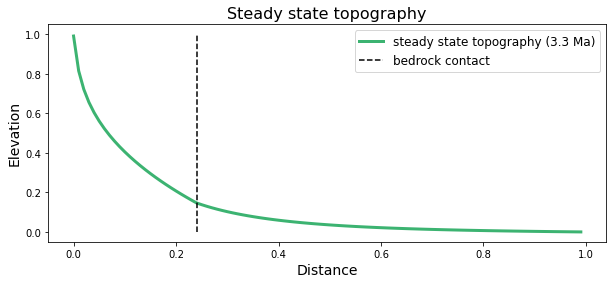

In [102]:
# great, now make a steady state profile figure
fig = plt.figure(figsize = (10, 4))

plt.plot((x_2/1000)/100, 
         (topography_CU - adjustment_CU)/200, 
         label = 'steady state topography (3.3 Ma)', 
         color = 'mediumseagreen', 
         linewidth = 3)
plt.xlabel('Distance', fontsize = 14)
plt.ylabel('Elevation', fontsize = 14)
plt.vlines(x = 0.24, 
           ymin = 0, 
           ymax = 1, 
           label = 'bedrock contact', 
           color = 'k', 
           linestyle = '--')
plt.title('Steady state topography', fontsize = 16)
plt.legend(fontsize = 12)

# plt.savefig('csdms2022_CU.png')
plt.show()

In [103]:
# now drop baselevel (ie raise all elevation nodes but the last)
# and re run and check out knicks

In [104]:
# now see if we can get the slope-area plotting to play nice

In [105]:
area = ((x_2)**2)/3

m, b = np.polyfit(np.log(area[1:]), np.log(slope_CU), 1)
m_up, b_up = np.polyfit(np.log(area[1:25]), np.log(slope_CU[:24]), 1)
m_down, b_down = np.polyfit(np.log(area[25:]), np.log(slope_CU[24:]), 1)

slope_fit = np.exp((m * np.log(area[1:])) + b)
slope_fit_up = np.exp((m_up * np.log(area[1:25])) + b_up)
slope_fit_down = np.exp((m_down * np.log(area[25:])) + b_down)

In [106]:
upper_bound_up_m = m_up + 0.07
lower_bound_up_m = m_up - 0.07

upper_bound_down_m = m_down + 0.07
lower_bound_down_m = m_down - 0.07

In [107]:
upper_bound_up_slope_fit = np.exp((upper_bound_up_m * np.log(area[1:25])) + b_up)
lower_bound_up_slope_fit = np.exp((lower_bound_up_m * np.log(area[1:25])) + b_up)

upper_bound_down_slope_fit = np.exp((upper_bound_down_m * np.log(area[25:])) + b_down)
lower_bound_down_slope_fit = np.exp((lower_bound_down_m * np.log(area[25:])) + b_down)

In [108]:
len(upper_bound_up_slope_fit)

24

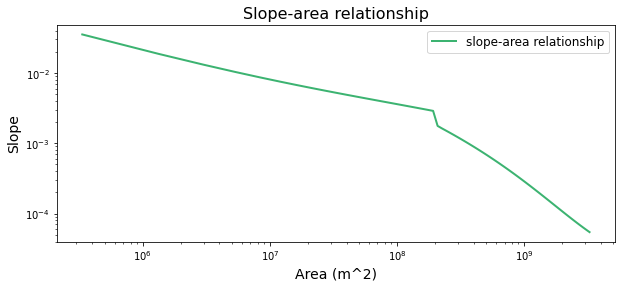

In [109]:
fig = plt.figure(figsize = (10, 4))

plt.plot(area[1:], slope_CU, label = 'slope-area relationship', color = 'mediumseagreen', linewidth = 2)
# plt.plot(area[1:], slope_fit, color = 'k', linestyle = '--', label = 'best fit')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Area (m^2)', fontsize = 14)
plt.ylabel('Slope', fontsize = 14)
plt.title('Slope-area relationship', fontsize = 16)
plt.legend(fontsize = 12)

# plt.savefig('csdms2022_SA.png')
plt.show()

In [110]:
# now just split them up into two plots according to lithologic boundary

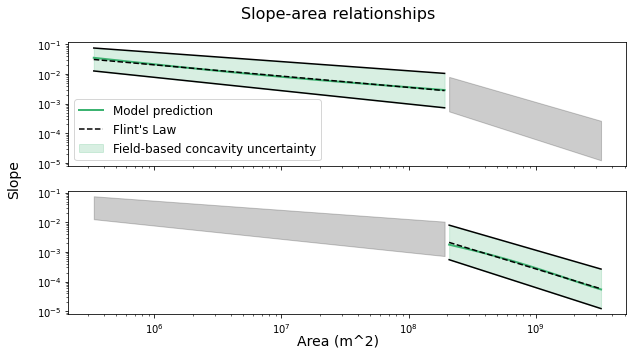

In [111]:
fig, axs = plt.subplots(2, figsize = (10, 5), sharex = True, sharey = True)
fig.text(0.04, 0.5, 'Slope', va='center', rotation='vertical', fontsize = 14)
fig.text(0.5, 0.04, 'Area (m^2)', ha='center', fontsize = 14)
fig.suptitle('Slope-area relationships', fontsize = 16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

axs[0].plot(area[1:25], slope_CU[:24], color = 'mediumseagreen', linewidth = 2, label = 'Model prediction')
axs[0].plot(area[1:25], slope_fit_up, color = 'k',linestyle = '--', label = "Flint's Law")
axs[0].plot(area[1:25], upper_bound_up_slope_fit, color = 'k')
axs[0].plot(area[1:25], lower_bound_up_slope_fit, color = 'k')
axs[0].fill_between(area[1:25], upper_bound_up_slope_fit, lower_bound_up_slope_fit, color = 'mediumseagreen', alpha = 0.2, label = 'Field-based concavity uncertainty')
axs[0].fill_between(area[25:], upper_bound_down_slope_fit, lower_bound_down_slope_fit, color = 'k', alpha = 0.2)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
# axs[0].set_title('Upstream', fontsize = 16)
axs[0].legend(loc = 'best', fontsize = 12)

axs[1].plot(area[25:], slope_CU[24:], color = 'mediumseagreen', linewidth = 2)
axs[1].plot(area[25:], slope_fit_down, color = 'k',linestyle = '--')
axs[1].plot(area[25:], upper_bound_down_slope_fit, color = 'k')
axs[1].plot(area[25:], lower_bound_down_slope_fit, color = 'k')
axs[1].fill_between(area[1:25], upper_bound_up_slope_fit, lower_bound_up_slope_fit, color = 'k', alpha = 0.2)
axs[1].fill_between(area[25:], upper_bound_down_slope_fit, lower_bound_down_slope_fit, color = 'mediumseagreen', alpha = 0.2)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
# axs[1].set_title('Downstream', fontsize = 16)

# plt.savefig('csdms2022_SA_up_down.png')
plt.show()

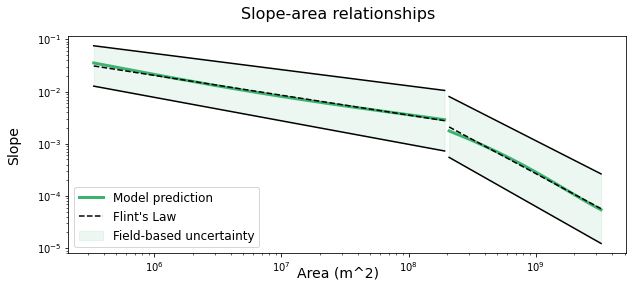

In [112]:
# what if I made the above just one figure?
fig, ax = plt.subplots(1, figsize = (10, 4), sharex = True, sharey = True)
fig.text(0.04, 0.5, 'Slope', va='center', rotation='vertical', fontsize = 14)
fig.text(0.5, 0.04, 'Area (m^2)', ha='center', fontsize = 14)
fig.suptitle('Slope-area relationships', fontsize = 16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

ax.plot(area[1:25], slope_CU[:24], color = 'mediumseagreen', linewidth = 3, label = 'Model prediction')
ax.plot(area[1:25], slope_fit_up, color = 'k',linestyle = '--', label = "Flint's Law")
ax.plot(area[1:25], upper_bound_up_slope_fit, color = 'k')
ax.plot(area[1:25], lower_bound_up_slope_fit, color = 'k')
ax.fill_between(area[1:25], upper_bound_up_slope_fit, lower_bound_up_slope_fit, color = 'mediumseagreen', alpha = 0.1, label = 'Field-based uncertainty')
# ax.fill_between(area[25:], upper_bound_down_slope_fit, lower_bound_down_slope_fit, color = 'k', alpha = 0.2)
ax.set_yscale('log')
ax.set_xscale('log')
# axs[0].set_title('Upstream', fontsize = 16)
ax.legend(loc = 'best', fontsize = 12)

ax.plot(area[25:], slope_CU[24:], color = 'mediumseagreen', linewidth = 3)
ax.plot(area[25:], slope_fit_down, color = 'k',linestyle = '--')
ax.plot(area[25:], upper_bound_down_slope_fit, color = 'k')
ax.plot(area[25:], lower_bound_down_slope_fit, color = 'k')
# ax.fill_between(area[1:25], upper_bound_up_slope_fit, lower_bound_up_slope_fit, color = 'k', alpha = 0.2)
ax.fill_between(area[25:], upper_bound_down_slope_fit, lower_bound_down_slope_fit, color = 'mediumseagreen', alpha = 0.1)
ax.set_yscale('log')
ax.set_xscale('log')
# axs[1].set_title('Downstream', fontsize = 16)

# plt.savefig('csdms2022_SA_up_down_single.png')
plt.show()

In [113]:
# heck yes
# now let's see what happens when we run the model with a high uplift rate

In [114]:
# create the input experiment
#HU stands for high uplift
HU = [x_2, dx_2, Hstar_2, H_2, etab_2, eta_2, beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.002, 1000000]

# and run away with it!
(slope_HU,
 sed_flux_HU,
 e_factor_HU,
 topography_HU,
 bedrock_elevation_HU,
 igneous_plucking_rate_HU,
 sedimentary_plucking_rate_HU,
 igneous_abrasion_rate_HU,
 sedimentary_abrasion_rate_HU,
 bedrock_erosion_rate_HU,
 attrition_rate_HU,
 sedimentation_rate_HU,
 sediment_thickness_HU,
 total_erosion_rate_HU,
 cum_time_HU) = two_lith_one_sed(*HU)

6734006.955965287


In [115]:
# check ss condition
print(total_erosion_rate_HU)

[ 1.99982540e-03  2.00002711e-03  2.00012547e-03  1.99994095e-03
  1.99958485e-03  1.99926408e-03  1.99913322e-03  1.99921217e-03
  1.99941955e-03  1.99967141e-03  1.99995012e-03  2.00031126e-03
  2.00076313e-03  2.00123445e-03  2.00178922e-03  2.00095615e-03
  2.00268284e-03  2.00643536e-03  1.98087431e-03  2.91102337e-03
  4.80413626e-03  1.75377585e-02 -6.54340619e-02  8.00303180e-02
 -2.64135256e-02  6.68497284e-05  1.26030711e-03  2.02259472e-03
  1.70623596e-03  1.49651063e-03  1.58916136e-03  1.77259435e-03
  1.96840299e-03  2.13615533e-03  2.23622293e-03  2.25163087e-03
  2.20262275e-03  2.12967747e-03  2.06397378e-03  2.01650730e-03
  1.98558642e-03  1.96655615e-03  1.95612890e-03  1.95252890e-03
  1.95444802e-03  1.96040086e-03  1.96869080e-03  1.97767131e-03
  1.98600931e-03  1.99282480e-03  1.99770218e-03  2.00061708e-03
  2.00182548e-03  2.00174772e-03  2.00086598e-03  1.99964332e-03
  1.99846764e-03  1.99762036e-03  1.99726742e-03  1.99746772e-03
  1.99819293e-03  1.99935

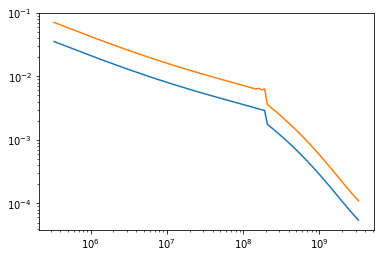

In [116]:
plt.plot(area[1:], slope_CU)
plt.plot(area[1:], slope_HU)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [117]:
# amazing
# now just need to transform these onto single plot, broken up as before

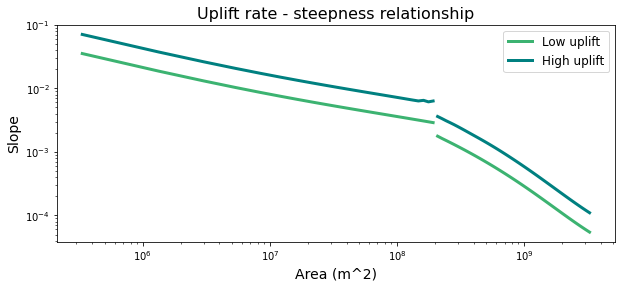

In [118]:
plt.figure(figsize = (10, 4))

plt.plot(area[1:25], slope_CU[:24], linewidth = 3, color = 'mediumseagreen', label = 'Low uplift')
plt.plot(area[25:], slope_CU[24:], linewidth = 3, color = 'mediumseagreen')
plt.plot(area[1:25], slope_HU[:24], linewidth = 3, color = 'teal', label = 'High uplift')
plt.plot(area[25:], slope_HU[24:], linewidth = 3, color = 'teal')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 12)
plt.xlabel('Area (m^2)', fontsize = 14)
plt.ylabel('Slope', fontsize = 14)
plt.title('Uplift rate - steepness relationship', fontsize = 16)

# plt.savefig('csdms2022_HU_LU.png')
plt.show()

In [119]:
# great, 
# now we want to design an experiment related to channel concavity increasing in the presence of resistant sediment
# for this, we just want to compare our model to a sediment-less model (SP)
# copy and paste stream power fxn below

In [120]:
# set up basic stuff

# grid
dx_1 = 1000
x_1 = np.arange(0, 100000, dx_1)

# elevation
eta_1 = np.zeros(len(x_1))

# set reasonable runoff rate in m/yr, see Rossi et al 2016 supplemental
r_1 = np.zeros(len(x_1))
r_1[:] = 0.3

# erodibility has both hard and soft rocks
k_1 = np.zeros(len(x_1))
k_1[:25] = 0.0001
k_1[25:] = 0.001

In [121]:
# now make the first function: pure stream power
# take out adaptive timstep stuff, only add it back in if it seems necessary

def stream_power(x,
                 dx,
                 eta,
                 k,
                 r,
                 c = 1, # should be 0.041, from W & S '19 (assuming constant geomorphically effective flow)
                 baselevel_rate = 0.001, # uplifting 1 mm/yr
                 num_steps = 100000, 
                 porosity = 0.55):
    
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    bedrock_ero[-1] = baselevel_rate
    q = r_1 * x  # discharge = distance downstream (first node is left edge of 0th cell)
    dt = 0.2 * dx * dx / (c*q[-1])  # "global" time-step size # mult by 0.2
    
    for i in range(num_steps):

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calc bedrock erosion rate from stream power (plucking)
        bedrock_ero[:-1] = k[1:] * q[1:] * S
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  calc change in bedrock elev
        eta[:-1] -= bedrock_ero[:-1] * dt
        
        if any(bedrock_ero[:] != baselevel_rate):
            continue
        else:
            break
            
        
    return (q, S, bedrock_ero, eta, i)

In [122]:
# now create an input experiment
stream_power_ss = [x_1, dx_1, eta_1, k_1, r_1]

# run experiment and catch outputs!
(discharge_SP,
 slope_SP,
 bedrock_erosion_rate_SP,
 topography_SP,
 i_SP) = stream_power(*stream_power_ss)

In [123]:
# check for ss condition
print(bedrock_erosion_rate_SP)

[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001]


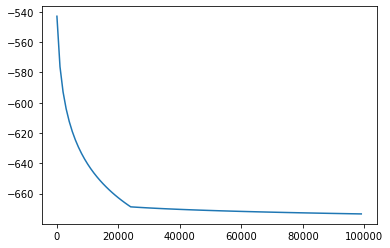

In [124]:
plt.plot(x_1, topography_SP)
# hurl yur

In [125]:
# okay, now we want to make slope-area plot that demonstrates that having sediment in the system results in both
# steeper (higher line)
# and more concave (higher slope line)
# rivers than when no sediment is present

# also maybe show a run where we jsut damp down contrast in two lithology model?
# run that one below real quick

In [126]:
# LC stands for low contrast
LC = [x_2, dx_2, Hstar_2, H_2, etab_2, eta_2, beta_ig_2 * 2.5, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2]

# and run away with it!
(slope_LC,
 sed_flux_LC,
 e_factor_LC,
 topography_LC,
 bedrock_elevation_LC,
 igneous_plucking_rate_LC,
 sedimentary_plucking_rate_LC,
 igneous_abrasion_rate_LC,
 sedimentary_abrasion_rate_LC,
 bedrock_erosion_rate_LC,
 attrition_rate_LC,
 sedimentation_rate_LC,
 sediment_thickness_LC,
 total_erosion_rate_LC,
 cum_time_LC) = two_lith_one_sed(*LC)

3367008.730460957


In [127]:
# check for ss
print(total_erosion_rate_LC)

[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001]


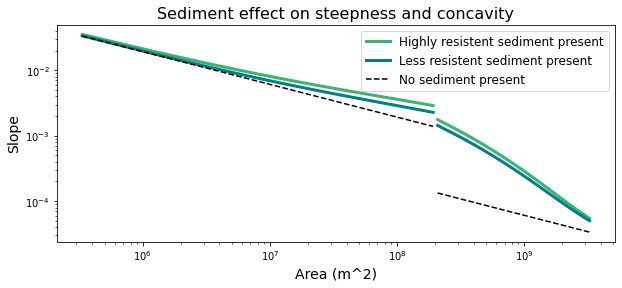

In [128]:
plt.figure(figsize = (10, 4))

plt.plot(area[1:25], slope_CU[:24], color = 'mediumseagreen', linewidth = 3, label = 'Highly resistent sediment present')
plt.plot(area[25:], slope_CU[24:], color = 'mediumseagreen', linewidth = 3)
plt.plot(area[1:25], slope_LC[:24], color = 'teal', linewidth = 3, label = 'Less resistent sediment present')
plt.plot(area[25:], slope_LC[24:], color = 'teal', linewidth = 3)
plt.plot(area[1:25], slope_SP[:24], linestyle = '--', color = 'k', label = 'No sediment present')
plt.plot(area[25:], slope_SP[24:], linestyle = '--', color = 'k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Area (m^2)', fontsize = 14)
plt.ylabel('Slope', fontsize = 14)
plt.title('Sediment effect on steepness and concavity', fontsize = 16)
plt.legend(fontsize = 12)

# plt.savefig('csdms2022_sed_steepness.png')
plt.show()

In [129]:
# and finally
# the moment we've all been waiting for
# the recording of upstream migrating knickpoints in response to baselevel change

In [130]:
# we've already done a standard run to steady state (CU)
# so now let's uplift topo (might have to make some copies of stuff first, tho)
# (referencing hydrosympoisum figs notebook to see)

In [131]:
# make a copy of all the outputs from that run
slope_CU_copy = slope_CU.copy()
sed_flux_CU_copy = sed_flux_CU.copy()
e_factor_CU_copy = e_factor_CU.copy()
topography_CU_copy = topography_CU.copy()
bedrock_elevation_CU_copy = bedrock_elevation_CU.copy()
igneous_plucking_rate_CU_copy = igneous_plucking_rate_CU.copy()
sedimentary_plucking_rate_CU_copy = sedimentary_plucking_rate_CU.copy()
igneous_abrasion_rate_CU_copy = igneous_abrasion_rate_CU.copy()
sedimentary_abrasion_rate_CU_copy = sedimentary_abrasion_rate_CU.copy()
bedrock_erosion_rate_CU_copy = bedrock_erosion_rate_CU.copy()
attrition_rate_CU_copy = attrition_rate_CU.copy()
sedimentation_rate_CU_copy = sedimentation_rate_CU.copy()
sediment_thickness_CU_copy = sediment_thickness_CU.copy()
total_erosion_rate_CU_copy = total_erosion_rate_CU.copy()
cum_time_CU_copy = cum_time_CU.copy()

In [132]:
# neat
# now we're going to make a new input topo (uplifted)
# and then make a bunch of copies of it to use as inputs to our experiments (see hydro nb)

In [133]:
# uplift all point on ss topography except outlet
uplift_topo = np.zeros(len(x_2))
uplift_topo[:-1] = topography_CU[:-1] + 200
uplift_topo[-1] = topography_CU[-1]

uplift_bedrock = np.zeros(len(x_2))
uplift_bedrock[:-1] = bedrock_elevation_CU[:-1] + 200
uplift_bedrock[-1] = bedrock_elevation_CU[-1]

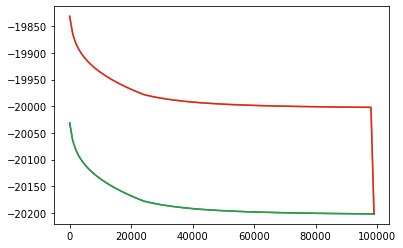

In [134]:
# check what it looks like
plt.plot(x_2, topography_CU)
plt.plot(x_2, uplift_topo)
plt.plot(x_2, bedrock_elevation_CU)
plt.plot(x_2, uplift_bedrock)
plt.show()

In [135]:
# very good.
# now make copies sensu hydrpsymposium figs nb
uplift_topo_copy = uplift_topo.copy()
uplift_bedrock_copy = uplift_bedrock.copy()

uplift_topo_1 = uplift_topo.copy()
uplift_bedrock_1 = uplift_bedrock.copy()

uplift_topo_5 = uplift_topo.copy()
uplift_bedrock_5 = uplift_bedrock.copy()

uplift_topo_10 = uplift_topo.copy()
uplift_bedrock_10 = uplift_bedrock.copy()

uplift_topo_25 = uplift_topo.copy()
uplift_bedrock_25 = uplift_bedrock.copy()

uplift_topo_50 = uplift_topo.copy()
uplift_bedrock_50 = uplift_bedrock.copy()

uplift_topo_100 = uplift_topo.copy()
uplift_bedrock_100 = uplift_bedrock.copy()

uplift_topo_250 = uplift_topo.copy()
uplift_bedrock_250 = uplift_bedrock.copy()

uplift_topo_500 = uplift_topo.copy()
uplift_bedrock_500 = uplift_bedrock.copy()

uplift_topo_1000 = uplift_topo.copy()
uplift_bedrock_1000 = uplift_bedrock.copy()

uplift_topo_5000 = uplift_topo.copy()
uplift_bedrock_5000 = uplift_bedrock.copy()

uplift_topo_10000 = uplift_topo.copy()
uplift_bedrock_10000 = uplift_bedrock.copy()

uplift_topo_25000 = uplift_topo.copy()
uplift_bedrock_25000 = uplift_bedrock.copy()

uplift_topo_50000 = uplift_topo.copy()
uplift_bedrock_50000 = uplift_bedrock.copy()

In [136]:
# now design some experiments!
# U stand for uplift
U1 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_1, uplift_topo_1, 
      beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 1]

U5 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_5, uplift_topo_5, 
      beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 5]

U10 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_10, uplift_topo_10, 
       beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 10]

U25 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_25, uplift_topo_25, 
       beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 25]

U50 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_50, uplift_topo_50, 
       beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 50]

U100 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_100, uplift_topo_100, 
        beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 100]

U250 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_250, uplift_topo_250, 
        beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 250]

U500 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_500, uplift_topo_500, 
        beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 500]

U1000 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_1000, uplift_topo_1000, 
         beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 1000]

U5000 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_5000, uplift_topo_5000, 
         beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 5000]

U10000 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_10000, uplift_topo_10000, 
          beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 10000]

U25000 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_25000, uplift_topo_25000, 
          beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 25000]

U50000 = [x_2, dx_2, Hstar_2, H_2, uplift_bedrock_50000, uplift_topo_50000, 
          beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.001, 50000]

In [137]:
# now run all input experiments, making copies of each
(uplift_eta_1,
uplift_etab_1,
uplift_S_1,
uplift_efac_1,
uplift_qs_1,
uplift_ero_plucking_ig_1, 
uplift_ero_plucking_sed_1,
uplift_ero_ab_ig_1,
uplift_ero_ab_sed_1,
uplift_bedrock_ero_rate_1, 
uplift_atr_1, 
uplift_sedimentation_rate_1, 
uplift_H_1, 
uplift_total_ero_rate_1,
uplift_cum_time_1) = two_lith_one_sed(*U1)

uplift_eta_1_copy = uplift_eta_1.copy()
uplift_etab_1_copy = uplift_etab_1.copy()
uplift_S_1_copy = uplift_S_1.copy()
uplift_efac_1_copy = uplift_efac_1.copy()
uplift_qs_1_copy = uplift_qs_1.copy()
uplift_ero_plucking_ig_1_copy = uplift_ero_plucking_ig_1.copy()
uplift_ero_plucking_sed_1_copy = uplift_ero_plucking_sed_1.copy()
uplift_ero_ab_ig_1_copy = uplift_ero_ab_ig_1.copy()
uplift_ero_ab_sed_1_copy = uplift_ero_ab_sed_1.copy()
uplift_bedrock_ero_rate_1_copy = uplift_bedrock_ero_rate_1.copy()
uplift_atr_1_copy = uplift_atr_1.copy()
uplift_sedimentation_rate_1_copy = uplift_sedimentation_rate_1.copy()
uplift_H_1_copy = uplift_H_1.copy()
uplift_total_ero_rate_1_copy = uplift_total_ero_rate_1.copy()
uplift_cum_time_1_copy = uplift_cum_time_1.copy()

6.745061757104081


In [138]:
# 5 timesteps
(uplift_eta_5,
uplift_etab_5,
uplift_S_5,
uplift_efac_5,
uplift_qs_5,
uplift_ero_plucking_ig_5, 
uplift_ero_plucking_sed_5,
uplift_ero_ab_ig_5,
uplift_ero_ab_sed_5,
uplift_bedrock_ero_rate_5, 
uplift_atr_5, 
uplift_sedimentation_rate_5, 
uplift_H_5, 
uplift_total_ero_rate_5,
uplift_cum_time_5) = two_lith_one_sed(*U5)

uplift_eta_5_copy = uplift_eta_5.copy()
uplift_etab_5_copy = uplift_etab_5.copy()
uplift_S_5_copy = uplift_S_5.copy()
uplift_efac_5_copy = uplift_efac_5.copy()
uplift_qs_5_copy = uplift_qs_5.copy()
uplift_ero_plucking_ig_5_copy = uplift_ero_plucking_ig_5.copy()
uplift_ero_plucking_sed_5_copy = uplift_ero_plucking_sed_5.copy()
uplift_ero_ab_ig_5_copy = uplift_ero_ab_ig_5.copy()
uplift_ero_ab_sed_5_copy = uplift_ero_ab_sed_5.copy()
uplift_bedrock_ero_rate_5_copy = uplift_bedrock_ero_rate_5.copy()
uplift_atr_5_copy = uplift_atr_5.copy()
uplift_sedimentation_rate_5_copy = uplift_sedimentation_rate_5.copy()
uplift_H_5_copy = uplift_H_5.copy()
uplift_total_ero_rate_5_copy = uplift_total_ero_rate_5.copy()
uplift_cum_time_5_copy = uplift_cum_time_5.copy()


# 10 timesteps
(uplift_eta_10,
uplift_etab_10,
uplift_S_10,
uplift_efac_10,
uplift_qs_10,
uplift_ero_plucking_ig_10, 
uplift_ero_plucking_sed_10,
uplift_ero_ab_ig_10,
uplift_ero_ab_sed_10,
uplift_bedrock_ero_rate_10, 
uplift_atr_10, 
uplift_sedimentation_rate_10, 
uplift_H_10, 
uplift_total_ero_rate_10,
uplift_cum_time_10) = two_lith_one_sed(*U10)

uplift_eta_10_copy = uplift_eta_10.copy()
uplift_etab_10_copy = uplift_etab_10.copy()
uplift_S_10_copy = uplift_S_10.copy()
uplift_efac_10_copy = uplift_efac_10.copy()
uplift_qs_10_copy = uplift_qs_10.copy()
uplift_ero_plucking_ig_10_copy = uplift_ero_plucking_ig_10.copy()
uplift_ero_plucking_sed_10_copy = uplift_ero_plucking_sed_10.copy()
uplift_ero_ab_ig_10_copy = uplift_ero_ab_ig_10.copy()
uplift_ero_ab_sed_10_copy = uplift_ero_ab_sed_10.copy()
uplift_bedrock_ero_rate_10_copy = uplift_bedrock_ero_rate_10.copy()
uplift_atr_10_copy = uplift_atr_10.copy()
uplift_sedimentation_rate_10_copy = uplift_sedimentation_rate_10.copy()
uplift_H_10_copy = uplift_H_10.copy()
uplift_total_ero_rate_10_copy = uplift_total_ero_rate_10.copy()
uplift_cum_time_10_copy = uplift_cum_time_10.copy()


# 25 timesteps
(uplift_eta_25,
uplift_etab_25,
uplift_S_25,
uplift_efac_25,
uplift_qs_25,
uplift_ero_plucking_ig_25, 
uplift_ero_plucking_sed_25,
uplift_ero_ab_ig_25,
uplift_ero_ab_sed_25,
uplift_bedrock_ero_rate_25, 
uplift_atr_25, 
uplift_sedimentation_rate_25, 
uplift_H_25, 
uplift_total_ero_rate_25,
uplift_cum_time_25) = two_lith_one_sed(*U25)

uplift_eta_25_copy = uplift_eta_25.copy()
uplift_etab_25_copy = uplift_etab_25.copy()
uplift_S_25_copy = uplift_S_25.copy()
uplift_efac_25_copy = uplift_efac_25.copy()
uplift_qs_25_copy = uplift_qs_25.copy()
uplift_ero_plucking_ig_25_copy = uplift_ero_plucking_ig_25.copy()
uplift_ero_plucking_sed_25_copy = uplift_ero_plucking_sed_25.copy()
uplift_ero_ab_ig_25_copy = uplift_ero_ab_ig_25.copy()
uplift_ero_ab_sed_25_copy = uplift_ero_ab_sed_25.copy()
uplift_bedrock_ero_rate_25_copy = uplift_bedrock_ero_rate_25.copy()
uplift_atr_25_copy = uplift_atr_25.copy()
uplift_sedimentation_rate_25_copy = uplift_sedimentation_rate_25.copy()
uplift_H_25_copy = uplift_H_25.copy()
uplift_total_ero_rate_25_copy = uplift_total_ero_rate_25.copy()
uplift_cum_time_25_copy = uplift_cum_time_25.copy()


# 50 timesteps
(uplift_eta_50,
uplift_etab_50,
uplift_S_50,
uplift_efac_50,
uplift_qs_50,
uplift_ero_plucking_ig_50, 
uplift_ero_plucking_sed_50,
uplift_ero_ab_ig_50,
uplift_ero_ab_sed_50,
uplift_bedrock_ero_rate_50, 
uplift_atr_50, 
uplift_sedimentation_rate_50, 
uplift_H_50, 
uplift_total_ero_rate_50,
uplift_cum_time_50) = two_lith_one_sed(*U50)

uplift_eta_50_copy = uplift_eta_50.copy()
uplift_etab_50_copy = uplift_etab_50.copy()
uplift_S_50_copy = uplift_S_50.copy()
uplift_efac_50_copy = uplift_efac_50.copy()
uplift_qs_50_copy = uplift_qs_50.copy()
uplift_ero_plucking_ig_50_copy = uplift_ero_plucking_ig_50.copy()
uplift_ero_plucking_sed_50_copy = uplift_ero_plucking_sed_50.copy()
uplift_ero_ab_ig_50_copy = uplift_ero_ab_ig_50.copy()
uplift_ero_ab_sed_50_copy = uplift_ero_ab_sed_50.copy()
uplift_bedrock_ero_rate_50_copy = uplift_bedrock_ero_rate_50.copy()
uplift_atr_50_copy = uplift_atr_50.copy()
uplift_sedimentation_rate_50_copy = uplift_sedimentation_rate_50.copy()
uplift_H_50_copy = uplift_H_50.copy()
uplift_total_ero_rate_50_copy = uplift_total_ero_rate_50.copy()
uplift_cum_time_50_copy = uplift_cum_time_50.copy()

33.98338283218085
67.35105909278813
168.40605741736616
336.7233155337197


In [139]:
# 100 timesteps
(uplift_eta_100,
uplift_etab_100,
uplift_S_100,
uplift_efac_100,
uplift_qs_100,
uplift_ero_plucking_ig_100, 
uplift_ero_plucking_sed_100,
uplift_ero_ab_ig_100,
uplift_ero_ab_sed_100,
uplift_bedrock_ero_rate_100, 
uplift_atr_100, 
uplift_sedimentation_rate_100, 
uplift_H_100, 
uplift_total_ero_rate_100,
uplift_cum_time_100) = two_lith_one_sed(*U100)

uplift_eta_100_copy = uplift_eta_100.copy()
uplift_etab_100_copy = uplift_etab_100.copy()
uplift_S_100_copy = uplift_S_100.copy()
uplift_efac_100_copy = uplift_efac_100.copy()
uplift_qs_100_copy = uplift_qs_100.copy()
uplift_ero_plucking_ig_100_copy = uplift_ero_plucking_ig_100.copy()
uplift_ero_plucking_sed_100_copy = uplift_ero_plucking_sed_100.copy()
uplift_ero_ab_ig_100_copy = uplift_ero_ab_ig_100.copy()
uplift_ero_ab_sed_100_copy = uplift_ero_ab_sed_100.copy()
uplift_bedrock_ero_rate_100_copy = uplift_bedrock_ero_rate_100.copy()
uplift_atr_100_copy = uplift_atr_100.copy()
uplift_sedimentation_rate_100_copy = uplift_sedimentation_rate_100.copy()
uplift_H_100_copy = uplift_H_100.copy()
uplift_total_ero_rate_100_copy = uplift_total_ero_rate_100.copy()
uplift_cum_time_100_copy = uplift_cum_time_100.copy()


# 250 timesteps
(uplift_eta_250,
uplift_etab_250,
uplift_S_250,
uplift_efac_250,
uplift_qs_250,
uplift_ero_plucking_ig_250, 
uplift_ero_plucking_sed_250,
uplift_ero_ab_ig_250,
uplift_ero_ab_sed_250,
uplift_bedrock_ero_rate_250, 
uplift_atr_250, 
uplift_sedimentation_rate_250, 
uplift_H_250, 
uplift_total_ero_rate_250,
uplift_cum_time_250) = two_lith_one_sed(*U250)

uplift_eta_250_copy = uplift_eta_250.copy()
uplift_etab_250_copy = uplift_etab_250.copy()
uplift_S_250_copy = uplift_S_250.copy()
uplift_efac_250_copy = uplift_efac_250.copy()
uplift_qs_250_copy = uplift_qs_250.copy()
uplift_ero_plucking_ig_250_copy = uplift_ero_plucking_ig_250.copy()
uplift_ero_plucking_sed_250_copy = uplift_ero_plucking_sed_250.copy()
uplift_ero_ab_ig_250_copy = uplift_ero_ab_ig_250.copy()
uplift_ero_ab_sed_250_copy = uplift_ero_ab_sed_250.copy()
uplift_bedrock_ero_rate_250_copy = uplift_bedrock_ero_rate_250.copy()
uplift_atr_250_copy = uplift_atr_250.copy()
uplift_sedimentation_rate_250_copy = uplift_sedimentation_rate_250.copy()
uplift_H_250_copy = uplift_H_250.copy()
uplift_total_ero_rate_250_copy = uplift_total_ero_rate_250.copy()
uplift_cum_time_250_copy = uplift_cum_time_250.copy()


# 500 timesteps
(uplift_eta_500,
uplift_etab_500,
uplift_S_500,
uplift_efac_500,
uplift_qs_500,
uplift_ero_plucking_ig_500, 
uplift_ero_plucking_sed_500,
uplift_ero_ab_ig_500,
uplift_ero_ab_sed_500,
uplift_bedrock_ero_rate_500, 
uplift_atr_500, 
uplift_sedimentation_rate_500, 
uplift_H_500, 
uplift_total_ero_rate_500,
uplift_cum_time_500) = two_lith_one_sed(*U500)

uplift_eta_500_copy = uplift_eta_500.copy()
uplift_etab_500_copy = uplift_etab_500.copy()
uplift_S_500_copy = uplift_S_500.copy()
uplift_efac_500_copy = uplift_efac_500.copy()
uplift_qs_500_copy = uplift_qs_500.copy()
uplift_ero_plucking_ig_500_copy = uplift_ero_plucking_ig_500.copy()
uplift_ero_plucking_sed_500_copy = uplift_ero_plucking_sed_500.copy()
uplift_ero_ab_ig_500_copy = uplift_ero_ab_ig_500.copy()
uplift_ero_ab_sed_500_copy = uplift_ero_ab_sed_500.copy()
uplift_bedrock_ero_rate_500_copy = uplift_bedrock_ero_rate_500.copy()
uplift_atr_500_copy = uplift_atr_500.copy()
uplift_sedimentation_rate_500_copy = uplift_sedimentation_rate_500.copy()
uplift_H_500_copy = uplift_H_500.copy()
uplift_total_ero_rate_500_copy = uplift_total_ero_rate_500.copy()
uplift_cum_time_500_copy = uplift_cum_time_500.copy()

673.6073253878249
1683.7564250383384
3367.627010023958


In [140]:
# 1000 timesteps
(uplift_eta_1000,
uplift_etab_1000,
uplift_S_1000,
uplift_efac_1000,
uplift_qs_1000,
uplift_ero_plucking_ig_1000, 
uplift_ero_plucking_sed_1000,
uplift_ero_ab_ig_1000,
uplift_ero_ab_sed_1000,
uplift_bedrock_ero_rate_1000, 
uplift_atr_1000, 
uplift_sedimentation_rate_1000, 
uplift_H_1000, 
uplift_total_ero_rate_1000,
uplift_cum_time_1000) = two_lith_one_sed(*U1000)

uplift_eta_1000_copy = uplift_eta_1000.copy()
uplift_etab_1000_copy = uplift_etab_1000.copy()
uplift_S_1000_copy = uplift_S_1000.copy()
uplift_efac_1000_copy = uplift_efac_1000.copy()
uplift_qs_1000_copy = uplift_qs_1000.copy()
uplift_ero_plucking_ig_1000_copy = uplift_ero_plucking_ig_1000.copy()
uplift_ero_plucking_sed_1000_copy = uplift_ero_plucking_sed_1000.copy()
uplift_ero_ab_ig_1000_copy = uplift_ero_ab_ig_1000.copy()
uplift_ero_ab_sed_1000_copy = uplift_ero_ab_sed_1000.copy()
uplift_bedrock_ero_rate_1000_copy = uplift_bedrock_ero_rate_1000.copy()
uplift_atr_1000_copy = uplift_atr_1000.copy()
uplift_sedimentation_rate_1000_copy = uplift_sedimentation_rate_1000.copy()
uplift_H_1000_copy = uplift_H_1000.copy()
uplift_total_ero_rate_1000_copy = uplift_total_ero_rate_1000.copy()
uplift_cum_time_1000_copy = uplift_cum_time_1000.copy()


# 5000 timesteps
(uplift_eta_5000,
uplift_etab_5000,
uplift_S_5000,
uplift_efac_5000,
uplift_qs_5000,
uplift_ero_plucking_ig_5000, 
uplift_ero_plucking_sed_5000,
uplift_ero_ab_ig_5000,
uplift_ero_ab_sed_5000,
uplift_bedrock_ero_rate_5000, 
uplift_atr_5000, 
uplift_sedimentation_rate_5000, 
uplift_H_5000, 
uplift_total_ero_rate_5000,
uplift_cum_time_5000) = two_lith_one_sed(*U5000)

uplift_eta_5000_copy = uplift_eta_5000.copy()
uplift_etab_5000_copy = uplift_etab_5000.copy()
uplift_S_5000_copy = uplift_S_5000.copy()
uplift_efac_5000_copy = uplift_efac_5000.copy()
uplift_qs_5000_copy = uplift_qs_5000.copy()
uplift_ero_plucking_ig_5000_copy = uplift_ero_plucking_ig_5000.copy()
uplift_ero_plucking_sed_5000_copy = uplift_ero_plucking_sed_5000.copy()
uplift_ero_ab_ig_5000_copy = uplift_ero_ab_ig_5000.copy()
uplift_ero_ab_sed_5000_copy = uplift_ero_ab_sed_5000.copy()
uplift_bedrock_ero_rate_5000_copy = uplift_bedrock_ero_rate_5000.copy()
uplift_atr_5000_copy = uplift_atr_5000.copy()
uplift_sedimentation_rate_5000_copy = uplift_sedimentation_rate_5000.copy()
uplift_H_5000_copy = uplift_H_5000.copy()
uplift_total_ero_rate_5000_copy = uplift_total_ero_rate_5000.copy()
uplift_cum_time_5000_copy = uplift_cum_time_5000.copy()

6734.070753830387
33671.541074481596


In [141]:
# just try making a figure with what you have
# no. comment out savefig stuff, go up and make timestep bigger, and thenm rerun

In [142]:
# 10000 timesteps
(uplift_eta_10000,
uplift_etab_10000,
uplift_S_10000,
uplift_efac_10000,
uplift_qs_10000,
uplift_ero_plucking_ig_10000, 
uplift_ero_plucking_sed_10000,
uplift_ero_ab_ig_10000,
uplift_ero_ab_sed_10000,
uplift_bedrock_ero_rate_10000, 
uplift_atr_10000, 
uplift_sedimentation_rate_10000, 
uplift_H_10000, 
uplift_total_ero_rate_10000,
uplift_cum_time_10000) = two_lith_one_sed(*U10000)

uplift_eta_10000_copy = uplift_eta_10000.copy()
uplift_etab_10000_copy = uplift_etab_10000.copy()
uplift_S_10000_copy = uplift_S_10000.copy()
uplift_efac_10000_copy = uplift_efac_10000.copy()
uplift_qs_10000_copy = uplift_qs_10000.copy()
uplift_ero_plucking_ig_10000_copy = uplift_ero_plucking_ig_10000.copy()
uplift_ero_plucking_sed_10000_copy = uplift_ero_plucking_sed_10000.copy()
uplift_ero_ab_ig_10000_copy = uplift_ero_ab_ig_10000.copy()
uplift_ero_ab_sed_10000_copy = uplift_ero_ab_sed_10000.copy()
uplift_bedrock_ero_rate_10000_copy = uplift_bedrock_ero_rate_10000.copy()
uplift_atr_10000_copy = uplift_atr_10000.copy()
uplift_sedimentation_rate_10000_copy = uplift_sedimentation_rate_10000.copy()
uplift_H_10000_copy = uplift_H_10000.copy()
uplift_total_ero_rate_10000_copy = uplift_total_ero_rate_10000.copy()
uplift_cum_time_10000_copy = uplift_cum_time_10000.copy()

67345.32889248403


In [143]:
# 25000 timesteps
(uplift_eta_25000,
uplift_etab_25000,
uplift_S_25000,
uplift_efac_25000,
uplift_qs_25000,
uplift_ero_plucking_ig_25000, 
uplift_ero_plucking_sed_25000,
uplift_ero_ab_ig_25000,
uplift_ero_ab_sed_25000,
uplift_bedrock_ero_rate_25000, 
uplift_atr_25000, 
uplift_sedimentation_rate_25000, 
uplift_H_25000, 
uplift_total_ero_rate_25000,
uplift_cum_time_25000) = two_lith_one_sed(*U25000)

uplift_eta_25000_copy = uplift_eta_25000.copy()
uplift_etab_25000_copy = uplift_etab_25000.copy()
uplift_S_25000_copy = uplift_S_25000.copy()
uplift_efac_25000_copy = uplift_efac_25000.copy()
uplift_qs_25000_copy = uplift_qs_25000.copy()
uplift_ero_plucking_ig_25000_copy = uplift_ero_plucking_ig_25000.copy()
uplift_ero_plucking_sed_25000_copy = uplift_ero_plucking_sed_25000.copy()
uplift_ero_ab_ig_25000_copy = uplift_ero_ab_ig_25000.copy()
uplift_ero_ab_sed_25000_copy = uplift_ero_ab_sed_25000.copy()
uplift_bedrock_ero_rate_25000_copy = uplift_bedrock_ero_rate_25000.copy()
uplift_atr_25000_copy = uplift_atr_25000.copy()
uplift_sedimentation_rate_25000_copy = uplift_sedimentation_rate_25000.copy()
uplift_H_25000_copy = uplift_H_25000.copy()
uplift_total_ero_rate_25000_copy = uplift_total_ero_rate_25000.copy()
uplift_cum_time_25000_copy = uplift_cum_time_25000.copy()

168351.28058910932


In [144]:
# 50000 timesteps
(uplift_eta_50000,
uplift_etab_50000,
uplift_S_50000,
uplift_efac_50000,
uplift_qs_50000,
uplift_ero_plucking_ig_50000, 
uplift_ero_plucking_sed_50000,
uplift_ero_ab_ig_50000,
uplift_ero_ab_sed_50000,
uplift_bedrock_ero_rate_50000, 
uplift_atr_50000, 
uplift_sedimentation_rate_50000, 
uplift_H_50000, 
uplift_total_ero_rate_50000,
uplift_cum_time_50000) = two_lith_one_sed(*U50000)

uplift_eta_50000_copy = uplift_eta_50000.copy()
uplift_etab_50000_copy = uplift_etab_50000.copy()
uplift_S_50000_copy = uplift_S_50000.copy()
uplift_efac_50000_copy = uplift_efac_50000.copy()
uplift_qs_50000_copy = uplift_qs_50000.copy()
uplift_ero_plucking_ig_50000_copy = uplift_ero_plucking_ig_50000.copy()
uplift_ero_plucking_sed_50000_copy = uplift_ero_plucking_sed_50000.copy()
uplift_ero_ab_ig_50000_copy = uplift_ero_ab_ig_50000.copy()
uplift_ero_ab_sed_50000_copy = uplift_ero_ab_sed_50000.copy()
uplift_bedrock_ero_rate_50000_copy = uplift_bedrock_ero_rate_50000.copy()
uplift_atr_50000_copy = uplift_atr_50000.copy()
uplift_sedimentation_rate_50000_copy = uplift_sedimentation_rate_50000.copy()
uplift_H_50000_copy = uplift_H_50000.copy()
uplift_total_ero_rate_50000_copy = uplift_total_ero_rate_50000.copy()
uplift_cum_time_50000_copy = uplift_cum_time_50000.copy()

336703.9260466244


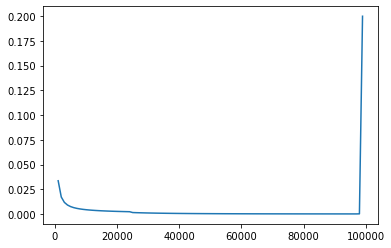

In [152]:
# hell yeah! just make sure stuff looks stable..
plt.plot(x_2[1:], uplift_eta_1)
plt.show()